In [1]:
from time import time

nb_start_time = time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

import random as r
import os
import math

from sklearn.preprocessing import MinMaxScaler

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def breaker():
    print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def getCol(x):
    return [cols for cols in x.columns]

def preprocess(x, *args):
    df = x.copy()
    df[args[0]] = df[args[0]].map({"trt_cp" : 0, "ctl_vehicle" : 1})
    df[args[1]] = df[args[1]].map({24 : 0, 48 : 1, 72 : 2})
    df[args[2]] = df[args[2]].map({"D1" : 0, "D2": 1})
    return df

def G_Scale(x=None, std_scale=5, scale=1, show_disp=True):
    mu    = x.shape[1]/2
    sigma = x.shape[1] * (2**std_scale)

    x_1 = np.subtract(x, mu)**2
    e_p = np.multiply(-0.5/sigma, x_1)

    g_f = (1/math.sqrt(math.pi * 2)) * np.exp(e_p) * scale

    x_Axis = np.arange(0, x.shape[1])
    x_   = np.subtract(x_Axis, mu)**2
    epf  = np.multiply(-0.5/sigma, x_)
    func = (1/math.sqrt(math.pi * 2)) * np.exp(epf) * scale

    if show_disp:
        plt.figure(figsize=(8,6))
        plt.plot(x_Axis, func, "r")
        plt.xlabel("Samples --->")
        plt.ylabel("Amplitude --->")
        plt.title("Gauss Function Used")
        plt.show()
    return g_f

def getModels(base_dir):
    models = []
    for dirname, _, filenames in os.walk(base_dir):
        for filename in filenames:
            if filename[0] == "M":
                models.append(filename)
    return models

mms = MinMaxScaler(feature_range=(0, 1), copy=True)

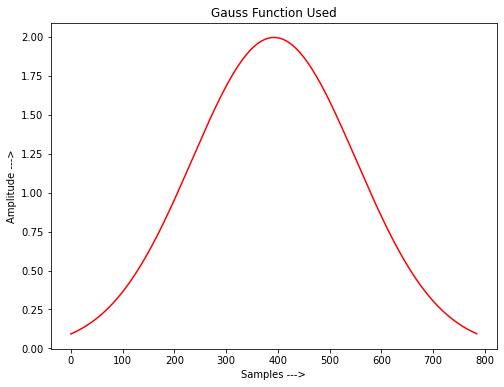

In [4]:
tr_lbls = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
ts_feat = pd.read_csv('../input/lish-moa/test_features.csv')

top_feats = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
              18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
              32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
              47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
              61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
              74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
              89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
              102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
              115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
              129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
              144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
              158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
              171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
              184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
              198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
              213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
              227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
              240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
              254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
              267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
              281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
              295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
              310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
              324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
              337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
              350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
              363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
              378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
              392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
              405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
              419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
              432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
              447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
              463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
              476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
              490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
              506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
              522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
              538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
              552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
              571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
              586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
              600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
              618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
              631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
              645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
              660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
              673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
              686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
              701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
              718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
              733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
              748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
              762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
              775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
              789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
              804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
              821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
              837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
              854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
              870, 871, 872, 873, 874]

num_features = len(top_feats)
num_classes  = tr_lbls.shape[1] - 1
columns      = getCol(tr_lbls)

X_test = ts_feat.iloc[:, top_feats].copy()

sigid = ts_feat.iloc[:, 0].values

X_test = preprocess(X_test, "cp_type", "cp_time", "cp_dose")

X_test = X_test.values

X_test = G_Scale(X_test, scale=5)

del tr_lbls

In [5]:
datapath_1 = "../input/10fcv-5savg-m-1-gaussian/"
datapath_2 = "../input/10fcv-5savg-m-2-gaussian/"

models_1 = getModels(datapath_1)
models_2 = getModels(datapath_2)

In [6]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
        
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

In [7]:
class CFG():
  ts_batch_size = 512

  IL = num_features
  HL_1 = [2048, 1024]
  HL_2 = [2048, 1024, 512]
  OL = num_classes

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = CFG()

In [8]:
class ANN(nn.Module):
  def __init__(this, IL=None, HL=None, OL=None):
    super(ANN, this).__init__()

    this.HL = HL
    this.DP1 = nn.Dropout(p=0.2)
    this.DP2 = nn.Dropout(p=0.5)

    if len(HL) == 2:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], HL[1]))

      this.BN3 = nn.BatchNorm1d(HL[1])
      this.FC3 = WN(nn.Linear(HL[1], OL))
    elif len(HL) == 3:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], HL[1]))

      this.BN3 = nn.BatchNorm1d(HL[1])
      this.FC3 = WN(nn.Linear(HL[1], HL[2]))

      this.BN4 = nn.BatchNorm1d(HL[2])
      this.FC4 = WN(nn.Linear(HL[2], OL))
    else:
      raise NotImplementedError("Only Allows Networks of Depth 2 or 3")

  def getOptimizer(this):
    return optim.Adam(this.parameters(), lr=1e-3, weight_decay=1e-5)
    
  def forward(this, x):
    if len(this.HL) == 2:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))
      x = this.BN2(x)
      x = this.DP2(x)
      x = F.relu(this.FC2(x))
      x = this.BN3(x)
      x = this.DP2(x)
      x = torch.sigmoid(this.FC3(x))
      return x
    else:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))
      x = this.BN2(x)
      x = this.DP2(x)
      x = F.relu(this.FC2(x))
      x = this.BN3(x)
      x = this.DP2(x)
      x = F.relu(this.FC3(x))
      x = this.BN4(x)
      x = this.DP2(x)
      x = torch.sigmoid(this.FC4(x))
      return x

In [9]:
torch.manual_seed(0)
Network_1 = ANN(cfg.IL, cfg.HL_1, cfg.OL)
Network_1.to(cfg.device)

torch.manual_seed(0)
Network_2 = ANN(cfg.IL, cfg.HL_2, cfg.OL)
Network_2.to(cfg.device)

ANN(
  (DP1): Dropout(p=0.2, inplace=False)
  (DP2): Dropout(p=0.5, inplace=False)
  (BN1): BatchNorm1d(785, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC1): Linear(in_features=785, out_features=2048, bias=True)
  (BN2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (BN3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC3): Linear(in_features=1024, out_features=512, bias=True)
  (BN4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC4): Linear(in_features=512, out_features=206, bias=True)
)

In [10]:
def ensemble_eval_fn(model_1=None, names_1=None, model_2=None, names_2=None, dataloader=None, num_obs_test=None):
  y_pred_1 = np.zeros((num_obs_test, num_classes))
  y_pred_2 = np.zeros((num_obs_test, num_classes))

  for name in names_1:
    Pred = torch.zeros(cfg.ts_batch_size, num_classes).to(cfg.device)
    model_1.load_state_dict(torch.load(datapath_1+name))
    model_1.eval()
    for feat in dataloader:
      feat = feat.to(cfg.device)
      with torch.no_grad():
        Prob = model_1(feat)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    Pred = Pred.cpu().numpy()
    y_pred_1 = np.add(y_pred_1, Pred)
  #y_pred = np.divide(y_pred, len(names))

  for name in names_2:
    Pred = torch.zeros(cfg.ts_batch_size, num_classes).to(cfg.device)
    model_2.load_state_dict(torch.load(datapath_2+name))
    model_2.eval()
    for feat in dataloader:
      feat = feat.to(cfg.device)
      with torch.no_grad():
        Prob = model_2(feat)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    Pred = Pred.cpu().numpy()
    y_pred_2 = np.add(y_pred_2, Pred)

  y_pred = np.add(y_pred_1, y_pred_2)
  y_pred = np.divide(y_pred, (len(names_1) + len(names_2)))
  return y_pred

In [11]:
ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = ensemble_eval_fn(Network_1, models_1, Network_2, models_2, ts_data, ts_data_setup.__len__())

eps = 1e-15
y_pred = np.clip(y_pred, eps, 1-eps)

final_data = np.concatenate((sigid.reshape(-1,1), y_pred), axis=1)

final_df = pd.DataFrame(final_data, columns=columns)
columns = columns[1:]
final_df.loc[ts_feat['cp_type']=='ctl_vehicle', columns] = 0
final_df.to_csv("./submission.csv",index=False)

In [12]:
final_df.head(5)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000764375,0.00122292,0.00179654,0.013243,0.0207257,0.00513432,0.00153963,0.00642939,0.000234602,...,0.000592369,0.00134077,0.00317895,0.00104496,0.000663098,0.000570527,0.00104255,0.0014171,0.00436185,0.00130101
1,id_001897cda,0.000314002,0.000946599,0.00188741,0.00256352,0.00183838,0.00192349,0.00377311,0.00946439,0.00652588,...,0.000818531,0.00092144,0.00459385,0.000337838,0.00891339,0.000427426,0.00741987,0.000776439,0.00268997,0.00354134
2,id_002429b5b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_00276f245,0.000630455,0.000710175,0.00183481,0.0129559,0.0168162,0.00510632,0.00278804,0.00526536,0.000267043,...,0.000528964,0.00116853,0.00289036,0.0129212,0.00418729,0.000459792,0.00156769,0.0021067,0.000849729,0.00244454
4,id_0027f1083,0.0012309,0.00102645,0.00199009,0.0138202,0.0208954,0.00391211,0.00481952,0.00204501,0.000366267,...,0.000795512,0.00046746,0.00461652,0.00249217,0.000875267,0.000457458,0.00146192,0.00197228,0.000356623,0.00129057


In [13]:
breaker()
print("Time Taken to Run Notebook : {:.2f} seconds".format(time() - nb_start_time))
breaker()


------------------------------

Time Taken to Run Notebook : 22.45 seconds

------------------------------

